In [1]:
pip install suntime

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install timezonefinder

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import os 
import pickle 
import numpy as np
from suntime import Sun
import datetime
import pytz
from timezonefinder import TimezoneFinder
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

# 1.Racial bias coefficient

In this part, we will compute the racial bias coefficient (RBC) which is described in our ReadMe of P3 Milestone. This coefficient measures the racial bias in stops decisions for each officer. To compute it, we need first stop with date, time, driver race and officer id. Moreover, a location (with longitude and latitude) is a plus but we can do without.

This frist part follow the section below:
<ul>
    <li>1.Data import</li>
    <li>2.Data preprocessing</li>
    <ul>
        <li>2.1.Drop missing values</li>
        <li>2.2.Keep stops for black/hispanic/white driver</li>
        <li>2.3.Check date</li>
        <li>2.4.Check time</li>
        <li>2.5.Check latitude and longitude</li>
        <li>2.6.Fill missing/wrong latitude and longitude</li>
        <li>2.7.Compute the UTC offset</li>
        <li>2.8.Compute the sunrise and sunset time</li>
        <li>2.9.Determine the lighting when the stops is done (dark, unsure, light)</li>
        <li>2.10.Drop stops with unsure lighting</li>
        <li>2.11.Get dummiers from subject race and lighting</li>
    </ul>
    <li>3.Data processing</li>
    <ul>
        <li>3.1.Collect number of stops of each officer for each category</li>
        <li>3.2.Keep only officer which has minimum 5 stops by category</li>
        <li>3.3.Compute the racial bias coefficient</li>
    </ul>
    <li>4.Analyze</li>
</ul>

## 1.1.Data import

We have a lot of files (89) but not all contains required columns (date, time, subject race and officer id hash) to compute our racial bias coefficient. We will iterate over all files and load those which have these columns. Moreover, if a file has columns latitude and longitude, we also load these columns.

In [4]:
path_original_datasets = './data/original/'

required_columns = ['date', 'time', 'subject_race', 'officer_id_hash']
usefull_columns = ['date', 'time', 'subject_race', 'officer_id_hash', 'lat', 'lng']

list_states_with_pedestrian_stops = ['az', 'sc']
list_cities_without_pedestrian_stops = ['little rock', 'anaheim', 'bakersfield', 'san bernardino', 
                                        'san diego', 'san francisco', 'stockton', 'hartford', 'saint petersburg', 
                                        'tampa', 'fort wayne', 'louisville', 'saint paul', 'charlotte', 'durham', 
                                        'fayetteville', 'greensboro', 'raleigh', 'winston-salem', 'henderson', 
                                        'albany', 'columbus', 'nashville', 'austin', 'garland', 'houston', 'plano', 
                                        'burlington', 'madison']

# Create a dataframe which will contains all stops
stops_df = pd.DataFrame(columns=(['state', 'agency'] + usefull_columns))

# Iterate over all files (name file format is : XXXXXXX_State_C1_C2_..._CN_Date where C1_C2_..._CN is the city name 
# with space remplaced by underscore and statewide if the data come from a state patrol)
for data_file in os.listdir(path_original_datasets):
    
    # Check if data come from state patrol
    if data_file.split("_")[2] == 'statewide':
        state = data_file.split("_")[1]
        agency = 'statewide'
        
        # Check if data come from a state patrol which includes pedestrian stops
        if state in list_states_with_pedestrian_stops:
            # If true, we do not load data
            continue 
    
    # Data come from a police patrol
    else:
        state = data_file.split("_")[1]
        # Get the agency city name
        i = 2
        agency = ""
        while(not(((data_file.split("_")[i])[0]).isdigit())):
            if i > 2:
                agency = agency + " "
            agency = agency + data_file.split("_")[i]
            i += 1
            
        # Check if the data come from a police patrol which does not include pedestrian stops
        if agency not in list_cities_without_pedestrian_stops:
            # If false, we do not load data
            continue
            
    # Try to load data with all usefull columns (i.e. with needed columns + latitude and longitude)
    try:
        df = pd.read_csv(path_original_datasets + data_file, sep=',', compression='zip', 
                         encoding='utf-8', low_memory=False, usecols=usefull_columns)
        df['state'] = state
        df['agency'] = agency
        
    # If we can not, try to load data with only needed columns
    except:
        try:
            df = pd.read_csv(path_original_datasets + data_file, sep=',', compression='zip', 
                             encoding='utf-8', low_memory=False, usecols=required_columns)
            df['state'] = state
            df['agency'] = agency
            
        # There are not all needed columns in the file, do not load it
        except ValueError as e:
            print("Can not load " + state + " " + agency)
            print(e)
            continue
    
    # Append the dataframe loaded to the global dataframe
    stops_df = stops_df.append(df, ignore_index=True)

Can not load ar little rock
Usecols do not match columns, columns expected but not found: ['officer_id_hash']
Can not load ca anaheim
Usecols do not match columns, columns expected but not found: ['officer_id_hash', 'subject_race', 'time']
Can not load ca san bernardino
Usecols do not match columns, columns expected but not found: ['officer_id_hash', 'subject_race']
Can not load ca san diego
Usecols do not match columns, columns expected but not found: ['officer_id_hash']
Can not load ca san francisco
Usecols do not match columns, columns expected but not found: ['officer_id_hash']
Can not load ca statewide
Usecols do not match columns, columns expected but not found: ['officer_id_hash', 'time']
Can not load ca stockton
Usecols do not match columns, columns expected but not found: ['time']
Can not load fl saint petersburg
Usecols do not match columns, columns expected but not found: ['subject_race']
Can not load fl tampa
Usecols do not match columns, columns expected but not found: ['o

Let's change the type of some columns to category type to gain space. Indeed, we have big data and this step can ensure no crash from RAM overflow and better performance.

In [5]:
stops_df['state'] = stops_df['state'].astype('category')
stops_df['agency'] = stops_df['agency'].astype('category')
stops_df['subject_race'] = stops_df['subject_race'].astype('category')
stops_df['officer_id_hash'] = stops_df['officer_id_hash'].astype('category')
stops_df

,state,agency,date,time,subject_race,officer_id_hash,lat,lng
0,ca,bakersfield,2016-06-22,14:48:00,hispanic,06727f04d2,35.380359,-118.987732
1,ca,bakersfield,2010-01-15,17:11:00,black,d86d0d33c4,35.373945,-118.991268
2,ca,bakersfield,2008-05-23,12:39:00,asian/pacific islander,f2756c1e52,35.354264,-119.054591
3,ca,bakersfield,2010-09-17,13:31:00,black,85308c0464,35.353913,-118.994131
4,ca,bakersfield,2010-05-07,09:52:00,white,b1f0a7b433,35.339810,-119.092147
...,...,...,...,...,...,...,...,...
84116045,wy,statewide,2012-12-31,23:11:00,white,a037160188,NaN,NaN
84116046,wy,statewide,2012-12-31,23:20:00,hispanic,7a5f2e1ac1,NaN,NaN
84116047,wy,statewide,2012-12-31,23:22:00,white,791f232f61,NaN,NaN
84116048,wy,statewide,2012-12-31,23:25:00,white,2dbb9fbcfc,NaN,NaN


Let's drop duplicated rows

In [6]:
stops_df = stops_df.drop_duplicates()
stops_df

,state,agency,date,time,subject_race,officer_id_hash,lat,lng
0,ca,bakersfield,2016-06-22,14:48:00,hispanic,06727f04d2,35.380359,-118.987732
1,ca,bakersfield,2010-01-15,17:11:00,black,d86d0d33c4,35.373945,-118.991268
2,ca,bakersfield,2008-05-23,12:39:00,asian/pacific islander,f2756c1e52,35.354264,-119.054591
3,ca,bakersfield,2010-09-17,13:31:00,black,85308c0464,35.353913,-118.994131
4,ca,bakersfield,2010-05-07,09:52:00,white,b1f0a7b433,35.339810,-119.092147
...,...,...,...,...,...,...,...,...
84116045,wy,statewide,2012-12-31,23:11:00,white,a037160188,NaN,NaN
84116046,wy,statewide,2012-12-31,23:20:00,hispanic,7a5f2e1ac1,NaN,NaN
84116047,wy,statewide,2012-12-31,23:22:00,white,791f232f61,NaN,NaN
84116048,wy,statewide,2012-12-31,23:25:00,white,2dbb9fbcfc,NaN,NaN


Since the dataset is huge, we will save chunks of 2 millions of stops

In [7]:
NB_ROWS_BY_FILES = int(2e6) #chunk of 2 millions rows
NUM_FILE = 1
path_extracted_dataset = './data/racial_bias_coefficient/extracted/'

# Iterate while the dataframe has more than 2 millions of rows
while stops_df.shape[0] > NB_ROWS_BY_FILES:
    
    # Get a chunk of the dataframe
    df = stops_df[0:NB_ROWS_BY_FILES]
    stops_df = stops_df[NB_ROWS_BY_FILES:stops_df.shape[0]]
        
    # Save the chunk into a CSV format
    df.to_csv(path_extracted_dataset + 'stops_extracted_RBC_' + str(NUM_FILE) + '.csv.zip',
              sep=',', compression='zip', encoding='utf-8', header=True, index=False)
    
    # Save the chunk into a pickle format 
    df.to_pickle(path_extracted_dataset + 'stops_extracted_RBC_' + str(NUM_FILE) + '.pkl.zip', 
                 compression='zip')
    
    NUM_FILE += 1
    
# Save the last chunk into a CSV format
stops_df.to_csv(path_extracted_dataset + 'stops_extracted_RBC_' + str(NUM_FILE) + '.csv.zip',
                sep=',', compression='zip', encoding='utf-8', header=True, index=False)
    
# Save the last chunk into a pickle format 
stops_df.to_pickle(path_extracted_dataset + 'stops_extracted_RBC_' + str(NUM_FILE) + '.pkl.zip', 
                   compression='zip')

print("Number of file: {}".format(NUM_FILE))

Number of file: 38


## 1.2.Data preprocessing

Load one of the previous chunks (do the data preprocessing pipeline for each chunk)

In [8]:
# Load from CSV format file (slower)

NUM_FILE = 1   #Indicate the num of the chunk wanted
path_extracted_dataset = './data/racial_bias_coefficient/extracted/'

stops_df = pd.read_csv(path_extracted_dataset + 'stops_extracted_RBC_' + str(NUM_FILE) + '.csv.zip', 
                       sep=',', compression='zip', encoding='utf-8', 
                       dtype={'state': 'category', 'agency': 'category', 'date': 'str', 'time': 'str',
                               'subject_race': 'category', 'officer_id_hash': 'category', 'lat': 'float64', 
                               'lng': 'float64'})

In [9]:
# Load from pickle format file (faster)
# !!! Only if pickle version is 4.0 !!!

NUM_FILE = 1    #Indicate the num of the chunk wanted
path_extracted_dataset = './data/racial_bias_coefficient/extracted/'

if pickle.format_version == '4.0':
    stops_df = pd.read_pickle(path_extracted_dataset + 'stops_extracted_RBC_' + str(NUM_FILE) + '.pkl.zip',
                              compression='zip')
    # Convert type to category
    stops_df['state'] = stops_df['state'].astype('category')
    stops_df['agency'] = stops_df['agency'].astype('category')
    stops_df['subject_race'] = stops_df['subject_race'].astype('category')
    stops_df['officer_id_hash'] = stops_df['officer_id_hash'].astype('category')
else:
    print("Your version of pickle is not 4.0, please use CSV loader")

In [10]:
stops_df

,state,agency,date,time,subject_race,officer_id_hash,lat,lng
0,ca,bakersfield,2016-06-22,14:48:00,hispanic,06727f04d2,35.380359,-118.987732
1,ca,bakersfield,2010-01-15,17:11:00,black,d86d0d33c4,35.373945,-118.991268
2,ca,bakersfield,2008-05-23,12:39:00,asian/pacific islander,f2756c1e52,35.354264,-119.054591
3,ca,bakersfield,2010-09-17,13:31:00,black,85308c0464,35.353913,-118.994131
4,ca,bakersfield,2010-05-07,09:52:00,white,b1f0a7b433,35.339810,-119.092147
...,...,...,...,...,...,...,...,...
2010550,co,statewide,2016-02-22,NaN,hispanic,717ca867a8,NaN,NaN
2010551,co,statewide,2016-02-22,NaN,white,2dc5c01c03,NaN,NaN
2010552,co,statewide,2016-02-22,NaN,white,6057dab030,NaN,NaN
2010553,co,statewide,2016-02-22,NaN,white,210f0f1630,NaN,NaN


### 1.2.1.Drop missing value

In [11]:
required_columns = ['date', 'time', 'subject_race', 'officer_id_hash']

# Drop row if there is at least one missing value in the required columns
stops_df = stops_df.dropna(how="any", axis=0, subset=required_columns)
stops_df

,state,agency,date,time,subject_race,officer_id_hash,lat,lng
0,ca,bakersfield,2016-06-22,14:48:00,hispanic,06727f04d2,35.380359,-118.987732
1,ca,bakersfield,2010-01-15,17:11:00,black,d86d0d33c4,35.373945,-118.991268
2,ca,bakersfield,2008-05-23,12:39:00,asian/pacific islander,f2756c1e52,35.354264,-119.054591
3,ca,bakersfield,2010-09-17,13:31:00,black,85308c0464,35.353913,-118.994131
4,ca,bakersfield,2010-05-07,09:52:00,white,b1f0a7b433,35.339810,-119.092147
...,...,...,...,...,...,...,...,...
189016,ca,bakersfield,2008-08-12,07:40:00,white,7a89a58beb,35.380051,-119.027016
189017,ca,bakersfield,2008-08-12,09:23:00,black,cd1b531dc5,35.354848,-119.038254
189020,ca,bakersfield,2016-05-28,01:15:00,white,172bfdfefb,35.339615,-119.047650
189021,ca,bakersfield,2016-08-25,14:15:00,white,edbe17f597,NaN,NaN


### 1.2.2.Keep black/hispanic/white drivers

To have consistent data, we will keep only stops for black/hispanic/white drivers

In [12]:
stops_df.subject_race.unique()

['hispanic', 'black', 'asian/pacific islander', 'white', 'unknown', 'other']
Categories (6, object): ['hispanic', 'black', 'asian/pacific islander', 'white', 'unknown', 'other']

In [13]:
# Filter dataframe on field subject race
filter_subject_race = ((stops_df.subject_race == 'black') | (stops_df.subject_race == 'hispanic') | (stops_df.subject_race == 'white'))
stops_df = stops_df[filter_subject_race]
stops_df

,state,agency,date,time,subject_race,officer_id_hash,lat,lng
0,ca,bakersfield,2016-06-22,14:48:00,hispanic,06727f04d2,35.380359,-118.987732
1,ca,bakersfield,2010-01-15,17:11:00,black,d86d0d33c4,35.373945,-118.991268
3,ca,bakersfield,2010-09-17,13:31:00,black,85308c0464,35.353913,-118.994131
4,ca,bakersfield,2010-05-07,09:52:00,white,b1f0a7b433,35.339810,-119.092147
5,ca,bakersfield,2011-10-10,14:06:00,white,d86d0d33c4,35.405021,-118.958681
...,...,...,...,...,...,...,...,...
189016,ca,bakersfield,2008-08-12,07:40:00,white,7a89a58beb,35.380051,-119.027016
189017,ca,bakersfield,2008-08-12,09:23:00,black,cd1b531dc5,35.354848,-119.038254
189020,ca,bakersfield,2016-05-28,01:15:00,white,172bfdfefb,35.339615,-119.047650
189021,ca,bakersfield,2016-08-25,14:15:00,white,edbe17f597,NaN,NaN


### 1.2.3.Check date format

Let's check that the date of stop is on format YYYY-MM-DD for all rows

In [14]:
def check_date_format(date):
    
    # Limit for date
    border_min = [2000, 1, 1]
    border_max = [2020, 12, 31]
    
    date = date.split('-')
    
    # Check if there are a year, a month and a day
    if len(date) != 3:
        return np.nan
    
    # Check is all part are number
    for i in range(3):
        if not str.isdigit(date[i]):
            return np.nan
    
    date = list(map(int, date))
    
    # Check range of date
    for i in range(3):
        if date[i] < border_min[i]:
            return np.nan
        if date[i] > border_max[i]:
            return np.nan
        
    return date

stops_df = stops_df.copy()
stops_df.date = stops_df.date.apply(check_date_format)
print('Part of wrong format date: {:.2%}'.format(stops_df.date.isna().mean()))
stops_df = stops_df.dropna(how="any", axis=0, subset=['date'])

Part of wrong format date: 0.00%


### 1.2.4.Check time format

Let's check that the time of stops is on format HH:MM:SS for all rows

In [15]:
def check_time_format(time):
    
    # Limit for time
    border_min = [0, 0, 0]
    border_max = [23, 59, 59]
    
    time = time.split(':')
    
    # Check if there are a hour, a minute and a second
    if len(time) != 3:
        return np.nan
    
    # Check is all part are number
    for i in range(3):
        if not str.isdigit(time[i]):
            return np.nan
    
    time = list(map(int, time))
    
    # Check range for time
    for i in range(3):
        if time[i] < border_min[i]:
            return np.nan
        if time[i] > border_max[i]:
            return np.nan
        
    return time

stops_df = stops_df.copy()
stops_df.time = stops_df.time.apply(check_time_format)
print('Part of wrong format time: {:.2%}'.format(stops_df.time.isna().mean()))
stops_df = stops_df.dropna(how="any", axis=0, subset=['time'])

Part of wrong format time: 0.00%


### 1.2.5.Check latitude & longitude 

Let's check if given latitude and longitude are correct. We will check if it is in the range of the latitude and longitude of the state where the stop was made.

NB: There are around 12 000 wrong latitude or/and longitude over the 70 millions stops (all chunks). We do not know if there are errors or if some state patrols can stop drivers in another state. So, he will handle it as error.

In [16]:
def check_latitude_longitude(line):
    
    # If nan, do not need to check, value is missing
    if np.isnan(line.lat) or np.isnan(line.lng):
        line.lat = np.nan
        line.lng = np.nan
        return line
    
    # Collect the range of latitude and longitude of the state
    state = str.upper(line.state)
    min_lat = infos_boundaries_states[state].loc['min_lat']
    max_lat = infos_boundaries_states[state].loc['max_lat']
    min_lng = infos_boundaries_states[state].loc['min_lng']
    max_lng = infos_boundaries_states[state].loc['max_lng']
    
    # Check if value are in range
    if line.lat > min_lat and line.lat < max_lat:
        if line.lng > min_lng and line.lng < max_lng:
            return line  # If true, do not change 
    
    # If value are out of range, return nan
    line.lat = np.nan
    line.lng = np.nan
    return line

In [17]:
# Load range of longitude and latitude for each state (json format)
path_infos_boundaries_states = "./data/info/state_boundaries.json"
infos_boundaries_states = pd.read_json(path_infos_boundaries_states)

stops_df = stops_df.copy()
stops_df = stops_df.apply(check_latitude_longitude, axis=1)
print('Part of missing or wrong latitude/longitude: {:.2%}'.format((stops_df.lat.isna() & stops_df.lng.isna()).mean()))

Part of missing or wrong latitude/longitude: 1.44%


### 1.2.6.Fill missing and false latitude and longitude

In this part, we will fill the missing and false latitude and longitude by applying the average of the state if data come from a state patrol or by the average of the city if data come from a police patrol.

NB: This method is not the best but location are not provided by all agencies.

In [18]:
def fill_na_latitude_longitude(line):
    
    # If lat and lng is correct (=not a nan value), return the line without any changement
    if not np.isnan(line.lat) and not np.isnan(line.lng):
        return line
    
    # If line come from a state patrol, return lat and lng from the average of the state
    if line.agency == 'statewide':
        line.lat = infos_center_states[line.state].latitude
        line.lng = infos_center_states[line.state].longitude
        return line
    
    # If line come from a municipal patrol, return lat and lng from the average of the city
    line.lat = infos_center_cities[line.agency].latitude
    line.lng = infos_center_states[line.state].longitude
    return line

In [19]:
# Load average lat and lng of the states (json format)
path_infos_center_states = "./data/info/state_center.json"
infos_center_states = pd.read_json(path_infos_center_states)

# Load average lat and lng of the cities (json format)
path_infos_center_cities = "./data/info/city_center.json"
infos_center_cities = pd.read_json(path_infos_center_cities)

stops_df = stops_df.copy()
stops_df = stops_df.apply(fill_na_latitude_longitude, axis=1)
stops_df

,state,agency,date,time,subject_race,officer_id_hash,lat,lng
0,ca,bakersfield,"[2016, 6, 22]","[14, 48, 0]",hispanic,06727f04d2,35.380359,-118.987732
1,ca,bakersfield,"[2010, 1, 15]","[17, 11, 0]",black,d86d0d33c4,35.373945,-118.991268
3,ca,bakersfield,"[2010, 9, 17]","[13, 31, 0]",black,85308c0464,35.353913,-118.994131
4,ca,bakersfield,"[2010, 5, 7]","[9, 52, 0]",white,b1f0a7b433,35.339810,-119.092147
5,ca,bakersfield,"[2011, 10, 10]","[14, 6, 0]",white,d86d0d33c4,35.405021,-118.958681
...,...,...,...,...,...,...,...,...
189016,ca,bakersfield,"[2008, 8, 12]","[7, 40, 0]",white,7a89a58beb,35.380051,-119.027016
189017,ca,bakersfield,"[2008, 8, 12]","[9, 23, 0]",black,cd1b531dc5,35.354848,-119.038254
189020,ca,bakersfield,"[2016, 5, 28]","[1, 15, 0]",white,172bfdfefb,35.339615,-119.047650
189021,ca,bakersfield,"[2016, 8, 25]","[14, 15, 0]",white,edbe17f597,35.393528,-119.746200


### 1.2.7.Compute UTC offset

Let's add a column UTC offset which contains the offset with respect to the latitude, longitude and date of the stop:

In [20]:
def compute_UTC_offset(line):
    
    # Collect the time zone from the latitude
    timezone_name = tf.timezone_at(lng=line.lng, lat=line.lat)
    
    # Return the UTC offset from the time zone and the date (winter or summer time)
    # NB: for few case timezone return a Nonetype which generate error (less than 100 errors over 70 millions of locations)
    try:
        utc_offset = int(pytz.timezone(timezone_name).localize(datetime.datetime(line.date[0],line.date[1],line.date[2])).strftime('%z'))/100
    except:
        utc_offset = np.nan
        
    return utc_offset

tf = TimezoneFinder()
stops_df = stops_df.copy()
stops_df['UTC_offset'] = stops_df.apply(compute_UTC_offset, axis=1)
stops_df = stops_df[stops_df.UTC_offset.isna() == False]
stops_df

,state,agency,date,time,subject_race,officer_id_hash,lat,lng,UTC_offset
0,ca,bakersfield,"[2016, 6, 22]","[14, 48, 0]",hispanic,06727f04d2,35.380359,-118.987732,-7.0
1,ca,bakersfield,"[2010, 1, 15]","[17, 11, 0]",black,d86d0d33c4,35.373945,-118.991268,-8.0
3,ca,bakersfield,"[2010, 9, 17]","[13, 31, 0]",black,85308c0464,35.353913,-118.994131,-7.0
4,ca,bakersfield,"[2010, 5, 7]","[9, 52, 0]",white,b1f0a7b433,35.339810,-119.092147,-7.0
5,ca,bakersfield,"[2011, 10, 10]","[14, 6, 0]",white,d86d0d33c4,35.405021,-118.958681,-7.0
...,...,...,...,...,...,...,...,...,...
189016,ca,bakersfield,"[2008, 8, 12]","[7, 40, 0]",white,7a89a58beb,35.380051,-119.027016,-7.0
189017,ca,bakersfield,"[2008, 8, 12]","[9, 23, 0]",black,cd1b531dc5,35.354848,-119.038254,-7.0
189020,ca,bakersfield,"[2016, 5, 28]","[1, 15, 0]",white,172bfdfefb,35.339615,-119.047650,-7.0
189021,ca,bakersfield,"[2016, 8, 25]","[14, 15, 0]",white,edbe17f597,35.393528,-119.746200,-7.0


### 1.2.8. Compute sunrise and sunset time

In [21]:
def compute_sunrise_time(line):
    
    sun = Sun(line.lat, line.lng)
    date = datetime.date(line.date[0], line.date[1], line.date[2])
    
    # Get the sunrise time for the location (lat and lng) and the date
    sunrise = sun.get_local_sunrise_time(date)
    
    # Suntime package does not return the same UTC than the UTC of the location
    # We need to calculate the diff of UTC between the location and the value
    # returned by Suntime
    sunrise_utc = int(sunrise.strftime('%z'))/100
    offset_hour = line.UTC_offset - sunrise_utc
    
    sunrise_hour = (sunrise.hour + offset_hour) % 24
    sunrise_minute = sunrise.minute
    sunrise_second = sunrise.second
    
    return [sunrise_hour, sunrise_minute, sunrise_second]

def compute_sunset_time(line):
    
    sun = Sun(line.lat, line.lng)
    date = datetime.date(line.date[0], line.date[1], line.date[2])
    
    # Get the sunrise time for the location (lat and lng) and the date
    sunset = sun.get_local_sunset_time(date)
    
    # Suntime package does not return the same UTC than the UTC of the location
    # We need to calculate the diff of UTC between the location and the value
    # returned by Suntime
    sunset_utc = int(sunset.strftime('%z'))/100
    offset_hour = line.UTC_offset - sunset_utc
    
    sunset_hour = (sunset.hour + offset_hour) % 24
    sunset_minute = sunset.minute
    sunset_second = sunset.second
    
    return [sunset_hour, sunset_minute, sunset_second]

stops_df = stops_df.copy()
stops_df['sunrise_time'] = stops_df.apply(compute_sunrise_time, axis=1)
stops_df['sunset_time'] = stops_df.apply(compute_sunset_time, axis=1)
stops_df

,state,agency,date,time,subject_race,officer_id_hash,lat,lng,UTC_offset,sunrise_time,sunset_time
0,ca,bakersfield,"[2016, 6, 22]","[14, 48, 0]",hispanic,06727f04d2,35.380359,-118.987732,-7.0,"[5.0, 42, 0]","[20.0, 14, 0]"
1,ca,bakersfield,"[2010, 1, 15]","[17, 11, 0]",black,d86d0d33c4,35.373945,-118.991268,-8.0,"[7.0, 5, 0]","[17.0, 7, 0]"
3,ca,bakersfield,"[2010, 9, 17]","[13, 31, 0]",black,85308c0464,35.353913,-118.994131,-7.0,"[6.0, 40, 0]","[19.0, 0, 0]"
4,ca,bakersfield,"[2010, 5, 7]","[9, 52, 0]",white,b1f0a7b433,35.339810,-119.092147,-7.0,"[5.0, 59, 0]","[19.0, 47, 0]"
5,ca,bakersfield,"[2011, 10, 10]","[14, 6, 0]",white,d86d0d33c4,35.405021,-118.958681,-7.0,"[6.0, 58, 0]","[18.0, 27, 0]"
...,...,...,...,...,...,...,...,...,...,...,...
189016,ca,bakersfield,"[2008, 8, 12]","[7, 40, 0]",white,7a89a58beb,35.380051,-119.027016,-7.0,"[6.0, 14, 0]","[19.0, 47, 0]"
189017,ca,bakersfield,"[2008, 8, 12]","[9, 23, 0]",black,cd1b531dc5,35.354848,-119.038254,-7.0,"[6.0, 14, 0]","[19.0, 47, 0]"
189020,ca,bakersfield,"[2016, 5, 28]","[1, 15, 0]",white,172bfdfefb,35.339615,-119.047650,-7.0,"[5.0, 44, 0]","[20.0, 4, 0]"
189021,ca,bakersfield,"[2016, 8, 25]","[14, 15, 0]",white,edbe17f597,35.393528,-119.746200,-7.0,"[6.0, 27, 0]","[19.0, 34, 0]"


### 1.2.9.Determine the lighting when the stops is done (dark, unsure, light)

We determine the lighting regarding to the sunrise and sunset time:
<ul>
    <li>Before sunrise: it is dark</li>
    <li>Between sunrise and sunset: it is light</li>
    <li>After sunset: it is dark</li>
</ul>
Since it is not dark nor light around one hour of sunrise/sunset, we take one hour of margin to be sure.
Moreover, since we have fill missing latitude and longitude with average of the state and some state has two UTC offsets, we take one more hour of margin to be sure.

In [22]:
def compute_lighting(line):
    
    # Compute the diff of time regarding the sunset
    # Value is negative if time is before sunset and positive if time is after
    time_diff_sunset = line.time[0] - line.sunset_time[0] \
    + (line.time[1] - line.sunset_time[1]) / 60 \
    + (line.time[2] - line.sunset_time[2]) / 3600
    
    # Compute the diff of time regarding the sunrise
    # Value is negative if time is before sunrise and positive if time is after
    time_diff_sunrise = line.time[0] - line.sunrise_time[0] \
    + (line.time[1] - line.sunrise_time[1]) / 60 \
    + (line.time[2] - line.sunrise_time[2]) / 3600
    
    # Before sunrise
    if time_diff_sunrise <= -2.0:
        return 'dark'
    # Between sunrise and sunset
    if time_diff_sunrise >= 2.0 and time_diff_sunset <= -2.0:
        return 'light'
    # After sunset
    if time_diff_sunset >= 2.0:
        return 'dark'
    
    # Around sunrise or sunset
    return 'unsure'

In [23]:
stops_df['lighting'] = stops_df.apply(compute_lighting, axis=1)
stops_df['lighting'] = stops_df['lighting'].astype('category')
stops_df

,state,agency,date,time,subject_race,officer_id_hash,lat,lng,UTC_offset,sunrise_time,sunset_time,lighting
0,ca,bakersfield,"[2016, 6, 22]","[14, 48, 0]",hispanic,06727f04d2,35.380359,-118.987732,-7.0,"[5.0, 42, 0]","[20.0, 14, 0]",light
1,ca,bakersfield,"[2010, 1, 15]","[17, 11, 0]",black,d86d0d33c4,35.373945,-118.991268,-8.0,"[7.0, 5, 0]","[17.0, 7, 0]",unsure
3,ca,bakersfield,"[2010, 9, 17]","[13, 31, 0]",black,85308c0464,35.353913,-118.994131,-7.0,"[6.0, 40, 0]","[19.0, 0, 0]",light
4,ca,bakersfield,"[2010, 5, 7]","[9, 52, 0]",white,b1f0a7b433,35.339810,-119.092147,-7.0,"[5.0, 59, 0]","[19.0, 47, 0]",light
5,ca,bakersfield,"[2011, 10, 10]","[14, 6, 0]",white,d86d0d33c4,35.405021,-118.958681,-7.0,"[6.0, 58, 0]","[18.0, 27, 0]",light
...,...,...,...,...,...,...,...,...,...,...,...,...
189016,ca,bakersfield,"[2008, 8, 12]","[7, 40, 0]",white,7a89a58beb,35.380051,-119.027016,-7.0,"[6.0, 14, 0]","[19.0, 47, 0]",unsure
189017,ca,bakersfield,"[2008, 8, 12]","[9, 23, 0]",black,cd1b531dc5,35.354848,-119.038254,-7.0,"[6.0, 14, 0]","[19.0, 47, 0]",light
189020,ca,bakersfield,"[2016, 5, 28]","[1, 15, 0]",white,172bfdfefb,35.339615,-119.047650,-7.0,"[5.0, 44, 0]","[20.0, 4, 0]",dark
189021,ca,bakersfield,"[2016, 8, 25]","[14, 15, 0]",white,edbe17f597,35.393528,-119.746200,-7.0,"[6.0, 27, 0]","[19.0, 34, 0]",light


### 1.2.10.Drop stops whith unsure lighting

Let's drop stop for which we are not sure of the lighting (i.e. around two hours between sunrise or sunset)

In [24]:
stops_df = stops_df[stops_df.lighting != 'unsure']
stops_df

,state,agency,date,time,subject_race,officer_id_hash,lat,lng,UTC_offset,sunrise_time,sunset_time,lighting
0,ca,bakersfield,"[2016, 6, 22]","[14, 48, 0]",hispanic,06727f04d2,35.380359,-118.987732,-7.0,"[5.0, 42, 0]","[20.0, 14, 0]",light
3,ca,bakersfield,"[2010, 9, 17]","[13, 31, 0]",black,85308c0464,35.353913,-118.994131,-7.0,"[6.0, 40, 0]","[19.0, 0, 0]",light
4,ca,bakersfield,"[2010, 5, 7]","[9, 52, 0]",white,b1f0a7b433,35.339810,-119.092147,-7.0,"[5.0, 59, 0]","[19.0, 47, 0]",light
5,ca,bakersfield,"[2011, 10, 10]","[14, 6, 0]",white,d86d0d33c4,35.405021,-118.958681,-7.0,"[6.0, 58, 0]","[18.0, 27, 0]",light
7,ca,bakersfield,"[2011, 6, 22]","[10, 47, 0]",white,42b4b015d7,35.381003,-119.038590,-7.0,"[5.0, 42, 0]","[20.0, 14, 0]",light
...,...,...,...,...,...,...,...,...,...,...,...,...
189015,ca,bakersfield,"[2017, 5, 6]","[15, 49, 0]",white,5382007ac2,35.352215,-119.002747,-7.0,"[6.0, 0, 0]","[19.0, 46, 0]",light
189017,ca,bakersfield,"[2008, 8, 12]","[9, 23, 0]",black,cd1b531dc5,35.354848,-119.038254,-7.0,"[6.0, 14, 0]","[19.0, 47, 0]",light
189020,ca,bakersfield,"[2016, 5, 28]","[1, 15, 0]",white,172bfdfefb,35.339615,-119.047650,-7.0,"[5.0, 44, 0]","[20.0, 4, 0]",dark
189021,ca,bakersfield,"[2016, 8, 25]","[14, 15, 0]",white,edbe17f597,35.393528,-119.746200,-7.0,"[6.0, 27, 0]","[19.0, 34, 0]",light


### 1.2.11.Get dummies from subject race and lighting

We will create columns for each subject race and each lighting:

In [25]:
stops_df = stops_df.copy()
stops_df['black_dark'] = ((stops_df.subject_race == 'black') & (stops_df.lighting == 'dark'))
stops_df['hispanic_dark'] = ((stops_df.subject_race == 'hispanic') & (stops_df.lighting == 'dark'))
stops_df['white_dark'] = ((stops_df.subject_race == 'white') & (stops_df.lighting == 'dark'))
stops_df['black_light'] = ((stops_df.subject_race == 'black') & (stops_df.lighting == 'light'))
stops_df['hispanic_light'] = ((stops_df.subject_race == 'hispanic') & (stops_df.lighting == 'light'))
stops_df['white_light'] = ((stops_df.subject_race == 'white') & (stops_df.lighting == 'light'))
stops_df

,state,agency,date,time,subject_race,officer_id_hash,lat,lng,UTC_offset,sunrise_time,sunset_time,lighting,black_dark,hispanic_dark,white_dark,black_light,hispanic_light,white_light
0,ca,bakersfield,"[2016, 6, 22]","[14, 48, 0]",hispanic,06727f04d2,35.380359,-118.987732,-7.0,"[5.0, 42, 0]","[20.0, 14, 0]",light,False,False,False,False,True,False
3,ca,bakersfield,"[2010, 9, 17]","[13, 31, 0]",black,85308c0464,35.353913,-118.994131,-7.0,"[6.0, 40, 0]","[19.0, 0, 0]",light,False,False,False,True,False,False
4,ca,bakersfield,"[2010, 5, 7]","[9, 52, 0]",white,b1f0a7b433,35.339810,-119.092147,-7.0,"[5.0, 59, 0]","[19.0, 47, 0]",light,False,False,False,False,False,True
5,ca,bakersfield,"[2011, 10, 10]","[14, 6, 0]",white,d86d0d33c4,35.405021,-118.958681,-7.0,"[6.0, 58, 0]","[18.0, 27, 0]",light,False,False,False,False,False,True
7,ca,bakersfield,"[2011, 6, 22]","[10, 47, 0]",white,42b4b015d7,35.381003,-119.038590,-7.0,"[5.0, 42, 0]","[20.0, 14, 0]",light,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189015,ca,bakersfield,"[2017, 5, 6]","[15, 49, 0]",white,5382007ac2,35.352215,-119.002747,-7.0,"[6.0, 0, 0]","[19.0, 46, 0]",light,False,False,False,False,False,True
189017,ca,bakersfield,"[2008, 8, 12]","[9, 23, 0]",black,cd1b531dc5,35.354848,-119.038254,-7.0,"[6.0, 14, 0]","[19.0, 47, 0]",light,False,False,False,True,False,False
189020,ca,bakersfield,"[2016, 5, 28]","[1, 15, 0]",white,172bfdfefb,35.339615,-119.047650,-7.0,"[5.0, 44, 0]","[20.0, 4, 0]",dark,False,False,True,False,False,False
189021,ca,bakersfield,"[2016, 8, 25]","[14, 15, 0]",white,edbe17f597,35.393528,-119.746200,-7.0,"[6.0, 27, 0]","[19.0, 34, 0]",light,False,False,False,False,False,True


### 1.2.12.Save data

In [26]:
path_preprocessed_dataset = './data/racial_bias_coefficient/preprocessed/'

# Save the dataframe into a CSV format
stops_df.to_csv(path_preprocessed_dataset + 'stops_preprocessed_RBC_' + str(NUM_FILE) + '.csv.zip',
                sep=',', compression='zip', encoding='utf-8', header=True, index=False)
    
# Save the dataframe into a pickle format
stops_df.to_pickle(path_preprocessed_dataset + 'stops_preprocessed_RBC_' + str(NUM_FILE) + '.pkl.zip', 
                   compression='zip')

## 1.3.Data processing

In [27]:
# Load from CSV format file (slower)
path_preprocessed_dataset = './data/racial_bias_coefficient/preprocessed/'
NB_FILES = 38
columns_to_use = ['state', 'agency', 'officer_id_hash', 'black_dark', 'hispanic_dark',
                  'white_dark', 'black_light', 'hispanic_light', 'white_light']

stops_df = pd.DataFrame(columns=columns_to_use)

# Iterate over all chunk
for NUM_FILE in range (1, NB_FILES + 1):
    df = pd.read_csv(path_preprocessed_dataset + 'stops_preprocessed_RBC_' + str(NUM_FILE) + '.csv.zip', 
                     sep=',', compression='zip', encoding='utf-8', usecols=columns_to_use, low_memory=False)
    
    stops_df = stops_df.append(df, ignore_index=True)

stops_df = stops_df.reset_index(drop=True)
stops_df.black_dark = stops_df.black_dark.astype('bool')
stops_df.hispanic_dark = stops_df.hispanic_dark.astype('bool')
stops_df.white_dark = stops_df.white_dark.astype('bool')
stops_df.black_light = stops_df.black_light.astype('bool')
stops_df.hispanic_light = stops_df.hispanic_light.astype('bool')
stops_df.white_light = stops_df.white_light.astype('bool')

In [28]:
# Load from pickle format file (faster)
# !!! Only if pickle version is 4.0 !!!
path_preprocessed_dataset = './data/racial_bias_coefficient/preprocessed/'
NB_FILES = 38
columns_to_use = ['state', 'agency', 'officer_id_hash', 'black_dark', 'hispanic_dark',
                  'white_dark', 'black_light', 'hispanic_light', 'white_light']

if pickle.format_version == '4.0':
    stops_df = pd.DataFrame(columns=columns_to_use)

    # Iterate over all chunk
    for NUM_FILE in range(1, NB_FILES + 1):
        df = pd.read_pickle(path_preprocessed_dataset + 'stops_preprocessed_RBC_' + str(NUM_FILE) + '.pkl.zip',
                            compression='zip')
        df = df[columns_to_use]
        stops_df = stops_df.append(df)
        
    stops_df = stops_df.reset_index(drop=True)
    
    stops_df.black_dark = stops_df.black_dark.astype('bool')
    stops_df.hispanic_dark = stops_df.hispanic_dark.astype('bool')
    stops_df.white_dark = stops_df.white_dark.astype('bool')
    stops_df.black_light = stops_df.black_light.astype('bool')
    stops_df.hispanic_light = stops_df.hispanic_light.astype('bool')
    stops_df.white_light = stops_df.white_light.astype('bool')
        
else:
    print("Your version of pickle is not 4.0, please use CSV loader")

In [29]:
stops_df

,state,agency,officer_id_hash,black_dark,hispanic_dark,white_dark,black_light,hispanic_light,white_light
0,ca,bakersfield,06727f04d2,False,False,False,False,True,False
1,ca,bakersfield,85308c0464,False,False,False,True,False,False
2,ca,bakersfield,b1f0a7b433,False,False,False,False,False,True
3,ca,bakersfield,d86d0d33c4,False,False,False,False,False,True
4,ca,bakersfield,42b4b015d7,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...
40380763,wy,statewide,a037160188,False,False,True,False,False,False
40380764,wy,statewide,7a5f2e1ac1,False,True,False,False,False,False
40380765,wy,statewide,791f232f61,False,False,True,False,False,False
40380766,wy,statewide,2dbb9fbcfc,False,False,True,False,False,False


### 1.3.1.Collect number of stops of each officer for each category

Let's group our stops by officer to count the number of stops in each category

In [30]:
columns = ['black_dark', 'hispanic_dark', 'white_dark', 'black_light', 'hispanic_light', 'white_light']
stops_by_officer_df = stops_df.groupby(['state', 'agency', 'officer_id_hash'], as_index=False).agg('sum')
stops_by_officer_df

,state,agency,officer_id_hash,black_dark,hispanic_dark,white_dark,black_light,hispanic_light,white_light
0,ca,bakersfield,003c6c14fa,4,0,2,0,1,0
1,ca,bakersfield,003db5b141,0,3,5,1,1,0
2,ca,bakersfield,008bb7857a,7,6,8,3,7,2
3,ca,bakersfield,0169a5aaa3,5,4,6,5,11,8
4,ca,bakersfield,0275d8533a,2,4,1,0,1,0
...,...,...,...,...,...,...,...,...,...
91606,wy,statewide,fcd4346f94,0,0,0,0,0,1
91607,wy,statewide,fd560266bf,2,5,92,3,7,287
91608,wy,statewide,fd7369647f,0,2,47,7,15,390
91609,wy,statewide,fdc7c7c89c,0,0,1,0,0,17


### 1.3.2. Keep only officer which has minimum 5 stops by category

To ensure qualitative data, we keep only officers which have stopped at least 5 drivers of each category

In [31]:
def check_minimum_stop(line):
    
    if line.black_dark < MINIMUM_STOP_BY_CATEGORY:
        return False
    if line.hispanic_dark < MINIMUM_STOP_BY_CATEGORY:
        return False
    if line.white_dark < MINIMUM_STOP_BY_CATEGORY:
        return False
    if line.black_light < MINIMUM_STOP_BY_CATEGORY:
        return False
    if line.hispanic_light < MINIMUM_STOP_BY_CATEGORY:
        return False
    if line.white_light < MINIMUM_STOP_BY_CATEGORY:
        return False
    
    return True


MINIMUM_STOP_BY_CATEGORY = 5
    
stops_by_officer_df = stops_by_officer_df.copy()
stops_by_officer_df['to_keep'] = stops_by_officer_df.apply(check_minimum_stop, axis=1)
stops_by_officer_df = stops_by_officer_df[stops_by_officer_df.to_keep]
stops_by_officer_df = stops_by_officer_df.drop(labels='to_keep', axis=1)
stops_by_officer_df

,state,agency,officer_id_hash,black_dark,hispanic_dark,white_dark,black_light,hispanic_light,white_light
9,ca,bakersfield,03db21bda9,7,27,104,192,740,2957
10,ca,bakersfield,03ebe6e831,11,31,27,8,7,5
23,ca,bakersfield,098a2909f4,11,43,32,20,43,58
30,ca,bakersfield,0c49356e8c,11,23,82,326,419,1572
36,ca,bakersfield,0de0087d2a,16,44,26,67,143,123
...,...,...,...,...,...,...,...,...,...
91538,wy,statewide,cb634fdabb,7,49,215,31,113,924
91556,wy,statewide,decf9509bb,8,19,193,17,66,646
91567,wy,statewide,e805341663,8,12,119,32,79,819
91593,wy,statewide,f4fd242b13,6,8,107,8,46,739


### 1.3.3.Compute the racial bias coefficient

Now, we have all the cleaned stuff we need. It is time to compute our racial bias coefficient.

In [32]:
def compute_racial_bias_coefficient(line):
    
    # Compute the racial bias coefficient design in the P3 Milestone
    # See the ReadMe.md of the github repo for more informations
    Nr = 3
    
    # beta_race_lighting = N_stop_race_lighting / (N_stop_black_lighting + N_stop_hispanic_lighting + N_stop_white_lighting)
    beta_black_light = line.black_light / (line.black_light + line.hispanic_light + line.white_light)
    beta_hispanic_light = line.hispanic_light / (line.black_light + line.hispanic_light + line.white_light)
    beta_white_light = line.white_light / (line.black_light + line.hispanic_light + line.white_light)
    beta_black_dark = line.black_dark / (line.black_dark + line.hispanic_dark + line.white_dark)
    beta_hispanic_dark = line.hispanic_dark / (line.black_dark + line.hispanic_dark + line.white_dark)
    beta_white_dark = line.white_dark / (line.black_dark + line.hispanic_dark + line.white_dark)

    # sigma_race = beta_race_light / beta_race_dark
    sigma_black = beta_black_light / beta_black_dark
    sigma_hispanic = beta_hispanic_light / beta_hispanic_dark
    sigma_white = beta_white_light / beta_white_dark
    
    # lambda_race = |(sigma_race / (sigma_black + sigma_hispanic + sigma_white)) - (1 / Nr))|
    lambda_black = np.abs((sigma_black / (sigma_black + sigma_hispanic + sigma_white)) - (1 / Nr))
    lambda_hispanic = np.abs((sigma_hispanic / (sigma_black + sigma_hispanic + sigma_white)) - (1 / Nr))
    lambda_white = np.abs((sigma_white / (sigma_black + sigma_hispanic + sigma_white)) - (1 / Nr))

    delta = 1 - (Nr / (np.exp(lambda_black) + np.exp(lambda_hispanic) + np.exp(lambda_white)))
    
    return delta

stops_by_officer_df['racial_bias_coefficient'] = stops_by_officer_df.apply(compute_racial_bias_coefficient, axis=1)
stops_by_officer_df

,state,agency,officer_id_hash,black_dark,hispanic_dark,white_dark,black_light,hispanic_light,white_light,racial_bias_coefficient
9,ca,bakersfield,03db21bda9,7,27,104,192,740,2957,0.005403
10,ca,bakersfield,03ebe6e831,11,31,27,8,7,5,0.186549
23,ca,bakersfield,098a2909f4,11,43,32,20,43,58,0.075628
30,ca,bakersfield,0c49356e8c,11,23,82,326,419,1572,0.070313
36,ca,bakersfield,0de0087d2a,16,44,26,67,143,123,0.043477
...,...,...,...,...,...,...,...,...,...,...
91538,wy,statewide,cb634fdabb,7,49,215,31,113,924,0.079935
91556,wy,statewide,decf9509bb,8,19,193,17,66,646,0.062121
91567,wy,statewide,e805341663,8,12,119,32,79,819,0.067485
91593,wy,statewide,f4fd242b13,6,8,107,8,46,739,0.148559


### 1.3.4.Save data

In [33]:
path_processed_dataset = './data/racial_bias_coefficient/processed/'

# Save the dataframe into a CSV format
stops_by_officer_df.to_csv(path_processed_dataset + 'stops_by_officer_processed_RBC.csv.zip',
                           sep=',', compression='zip', encoding='utf-8', header=True, index=False)
    
# Save the dataframe into a pickle format 
stops_by_officer_df.to_pickle(path_processed_dataset + 'stops_by_officer_processed_RBC.pkl.zip', 
                              compression='zip')

## 1.4.Analyze

In [34]:
# Load from CSV format file (slower)
path_processed_dataset = './data/racial_bias_coefficient/processed/'
columns = ['state', 'agency', 'officer_id_hash', 'racial_bias_coefficient']

stops_by_officer_df = pd.read_csv(path_processed_dataset + 'stops_by_officer_processed_RBC.csv.zip', 
                                  sep=',', compression='zip', encoding='utf-8', usecols=columns)

In [3]:
# Load from pickle format file (faster)
# !!! Only if pickle version is 4.0 !!!
path_processed_dataset = './data/racial_bias_coefficient/processed/'

if pickle.format_version == '4.0':

    stops_by_officer_df = pd.read_pickle(path_processed_dataset + 'stops_by_officer_processed_RBC.pkl.zip',
                                         compression='zip')
    
else:
    print("Your version of pickle is not 4.0, please use CSV loader")


In [24]:
stops_by_officer_df

,state,agency,officer_id_hash,black_dark,hispanic_dark,white_dark,black_light,hispanic_light,white_light,racial_bias_coefficient
9,ca,bakersfield,03db21bda9,7,27,104,192,740,2957,0.005403
10,ca,bakersfield,03ebe6e831,11,31,27,8,7,5,0.186549
23,ca,bakersfield,098a2909f4,11,43,32,20,43,58,0.075628
30,ca,bakersfield,0c49356e8c,11,23,82,326,419,1572,0.070313
36,ca,bakersfield,0de0087d2a,16,44,26,67,143,123,0.043477
...,...,...,...,...,...,...,...,...,...,...
91538,wy,statewide,cb634fdabb,7,49,215,31,113,924,0.079935
91556,wy,statewide,decf9509bb,8,19,193,17,66,646,0.062121
91567,wy,statewide,e805341663,8,12,119,32,79,819,0.067485
91593,wy,statewide,f4fd242b13,6,8,107,8,46,739,0.148559


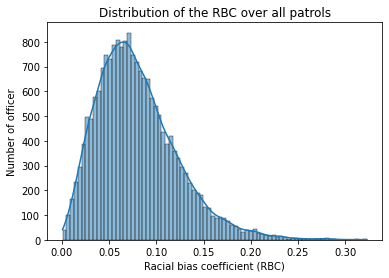

In [27]:
hist_global = sns.histplot(x=stops_by_officer_df.racial_bias_coefficient, kde=True)
hist_global.set(xlabel='Racial bias coefficient (RBC)', ylabel='Number of officer',
                title='Distribution of the RBC over all patrols')
plt.savefig('./result/hist_global_RBC.png')

[Text(0.5, 0, 'Racial bias coefficient (RBC)'),
 Text(0, 0.5, 'Number of officer'),
 Text(0.5, 1.0, 'Distribution of the RBC over all state patrols')]

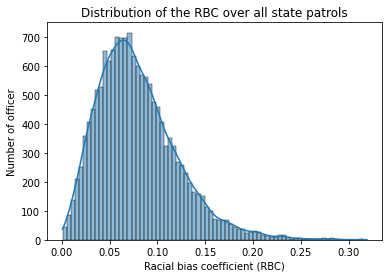

In [139]:
hist_state_patrol = sns.histplot(x=stops_by_officer_df[stops_by_officer_df.agency == 'statewide'].racial_bias_coefficient, kde=True)
hist_state_patrol.set(xlabel='Racial bias coefficient (RBC)', ylabel='Number of officer',
                      title='Distribution of the RBC over all state patrols')

[Text(0.5, 0, 'Racial bias coefficient (RBC)'),
 Text(0, 0.5, 'Number of officer'),
 Text(0.5, 1.0, 'Distribution of the RBC over all municipal patrols')]

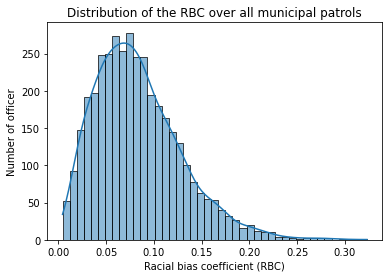

In [140]:
hist_municipal_patrol = sns.histplot(x=stops_by_officer_df[stops_by_officer_df.agency != 'statewide'].racial_bias_coefficient, kde=True)
hist_municipal_patrol.set(xlabel='Racial bias coefficient (RBC)', ylabel='Number of officer',
                          title='Distribution of the RBC over all municipal patrols')

[Text(0.5, 0, 'Raciak bias coefficient (RBC)'),
 Text(0, 0.5, ''),
 Text(0.5, 1.0, 'Distribution of the RBC over state/municipal patrols')]

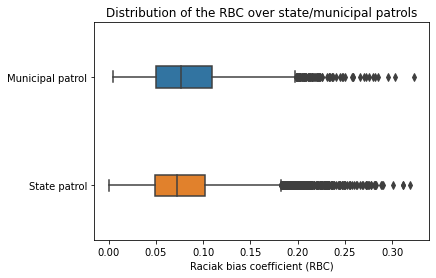

In [149]:
stops_by_officer_df['patrol'] = stops_by_officer_df.agency.apply(lambda x: 'State patrol' if x == 'statewide' else 'Municipal patrol')
box_state_municipal = sns.boxplot(x=stops_by_officer_df.racial_bias_coefficient, y=stops_by_officer_df.patrol, width=0.2)
box_state_municipal.set(xlabel='Raciak bias coefficient (RBC)', ylabel='',
                        title='Distribution of the RBC over state/municipal patrols')

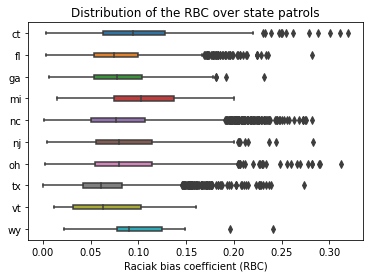

In [4]:
box_state = sns.boxplot(x=stops_by_officer_df[stops_by_officer_df.agency == 'statewide'].racial_bias_coefficient, y=stops_by_officer_df[stops_by_officer_df.agency == 'statewide'].state, width=0.2)
box_state.set(xlabel='Raciak bias coefficient (RBC)', ylabel='',
              title='Distribution of the RBC over state patrols')
plt.savefig('./result/box_state_patrol_RBC.png')

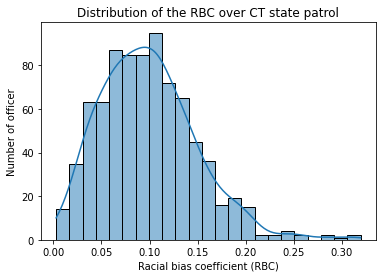

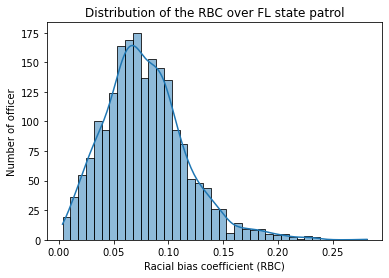

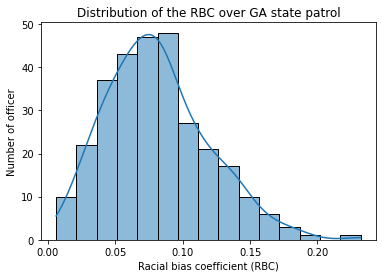

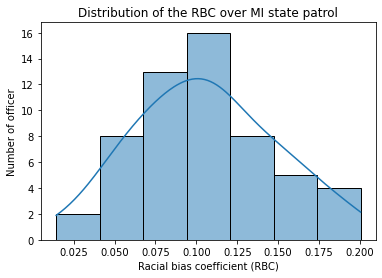

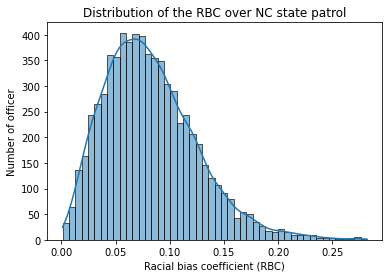

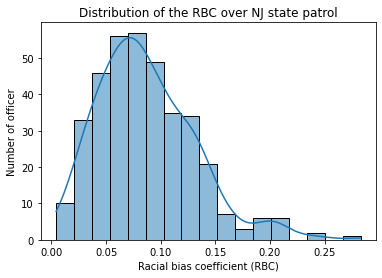

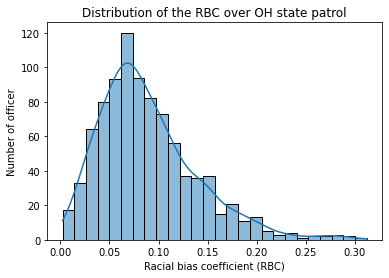

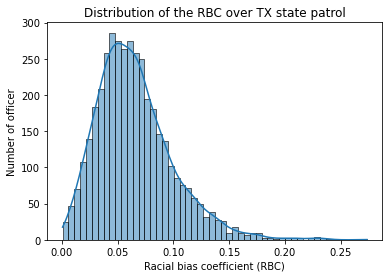

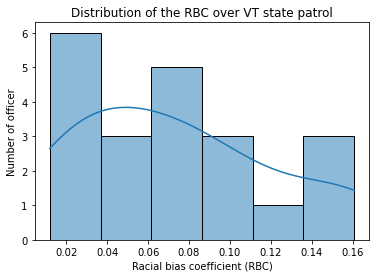

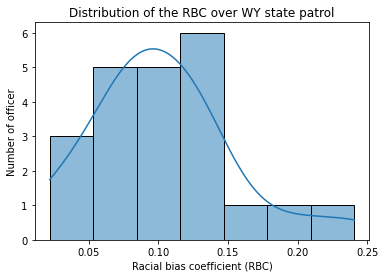

In [165]:
list_state_patrols = stops_by_officer_df[stops_by_officer_df.agency == 'statewide'].state.unique()

for state_patrol in list_state_patrols:
    hist = sns.histplot(x=stops_by_officer_df[(stops_by_officer_df.agency == 'statewide') & (stops_by_officer_df.state == state_patrol)].racial_bias_coefficient, 
                        kde=True)
    hist.set(xlabel='Racial bias coefficient (RBC)', ylabel='Number of officer',
             title='Distribution of the RBC over ' + str.upper(state_patrol) + ' state patrol')
    plt.show()

[Text(0.5, 0, 'Raciak bias coefficient (RBC)'),
 Text(0, 0.5, ''),
 Text(0.5, 1.0, 'Distribution of the RBC over municipal patrols')]

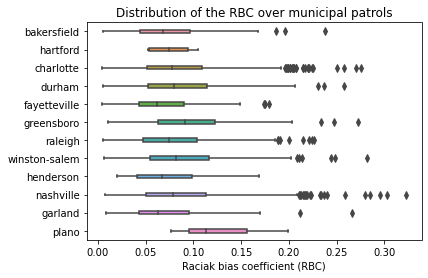

In [153]:
box_municipal = sns.boxplot(x=stops_by_officer_df[stops_by_officer_df.agency != 'statewide'].racial_bias_coefficient, y=stops_by_officer_df[stops_by_officer_df.agency != 'statewide'].agency, width=0.2)
box_municipal.set(xlabel='Raciak bias coefficient (RBC)', ylabel='',
                  title='Distribution of the RBC over municipal patrols')

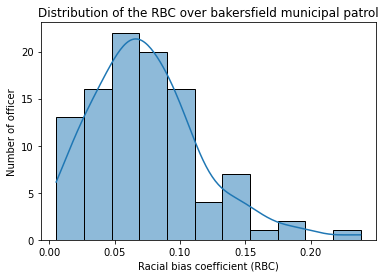

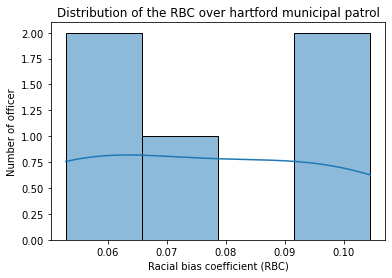

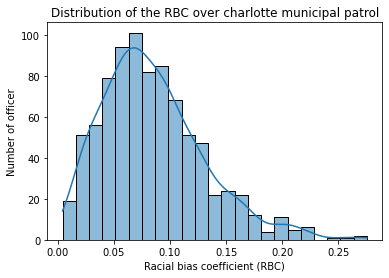

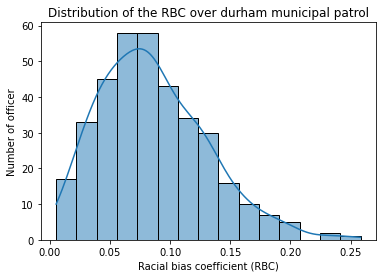

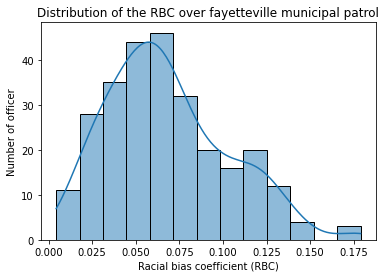

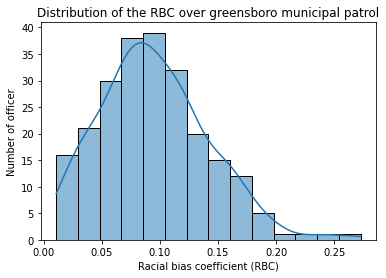

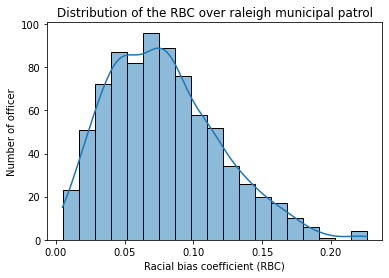

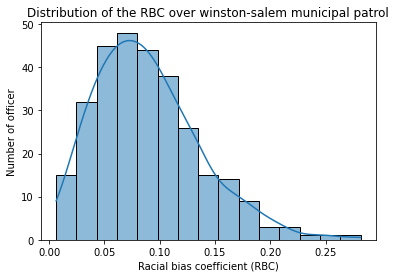

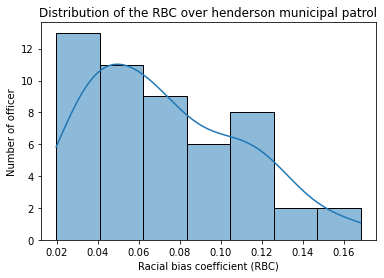

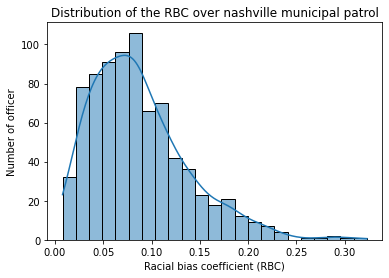

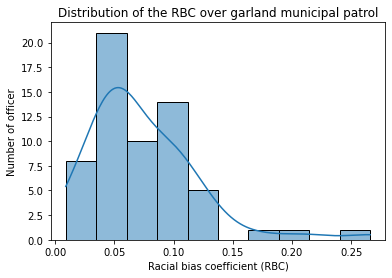

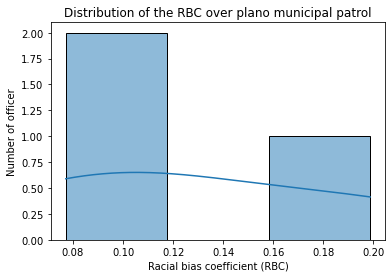

In [166]:
list_municipal_patrols = stops_by_officer_df[stops_by_officer_df.agency != 'statewide'].agency.unique()

for municipal_patrol in list_municipal_patrols:
    hist = sns.histplot(x=stops_by_officer_df[stops_by_officer_df.agency == municipal_patrol].racial_bias_coefficient, 
                        kde=True)
    hist.set(xlabel='Racial bias coefficient (RBC)', ylabel='Number of officer',
             title='Distribution of the RBC over ' + municipal_patrol + ' municipal patrol')
    plt.show()

# 2.Racial bias observation

In this second part, we will try to observe if some characteristics have an impact on the racial bias stops decisions with an observation of the correlation between different features and the racial bias coefficient.

This part follow the sections below:
<ul>
    <li>1.Data import</li>
    <li>2.Data preprocessing</li>
    <ul>
        <li>2.1.Check age</li>
        <li>2.2.Check years of service</li>
        <li>2.3.Check sex</li>
        <li>2.4.Check race</li>
        <li>2.5.Compute officer mean age</li>
        <li>2.6.Compute officer mean years of services</li>
        <li>2.7.Compute officer sex</li>
        <li>2.8.Compute officer race</li>
        <li>2.9.Append features to RBC dataframe</li>
    </ul>
    <li>3.Analyze</li>
</ul>

## 2.1.Data import

In this part, we want to recover general information for officer for who we have computed a racial bias coefficient. We are looking to sex, race, age and years of service (other fields are not exploitable).

In [2]:
path_original_datasets = './data/original/'

required_columns = ['date', 'time', 'subject_race', 'officer_id_hash']
usefull_columns = ['officer_id_hash', 'officer_sex', 'officer_age', 'officer_race', 'officer_years_of_service']

list_states_with_pedestrian_stops = ['az', 'sc']
list_cities_without_pedestrian_stops = ['little rock', 'anaheim', 'bakersfield', 'san bernardino', 
                                        'san diego', 'san francisco', 'stockton', 'hartford', 'saint petersburg', 
                                        'tampa', 'fort wayne', 'louisville', 'saint paul', 'charlotte', 'durham', 
                                        'fayetteville', 'greensboro', 'raleigh', 'winston-salem', 'henderson', 
                                        'albany', 'columbus', 'nashville', 'austin', 'garland', 'houston', 'plano', 
                                        'burlington', 'madison']

officers_infos_df = pd.DataFrame(columns=['state', 'agency'] + usefull_columns)

# Iterate over all files
for data_file in os.listdir(path_original_datasets):
    
    # Check if data come from state patrol
    if data_file.split("_")[2] == 'statewide':
        state = data_file.split("_")[1]
        agency = 'statewide'
        
        # Check if data come from a state patrol which includes pedestrian stops
        if state in list_states_with_pedestrian_stops:
            # If true, we do not load data
            continue 
    
    # Data come from a police patrol
    else:
        state = data_file.split("_")[1]
        # Get the agency city name
        i = 2
        agency = ""
        while(not(((data_file.split("_")[i])[0]).isdigit())):
            if i > 2:
                agency = agency + " "
            agency = agency + data_file.split("_")[i]
            i += 1
            
        # Check if the data come from a police patrol which does not include pedestrian stops
        if agency not in list_cities_without_pedestrian_stops:
            # If false, we do not load data
            continue
                         
    try:
        # We keep the same file that in the previous part (i.e. we keep only file which contains
        # the required columns). Check only one row of the file, if error, the file was not take
        # in the previous part, we continue with the next file
        df = pd.read_csv(path_original_datasets + data_file, sep=',', compression='zip', 
                         encoding='utf-8', low_memory=False, usecols=required_columns, nrows=1)
        
        # If the file comes from previous files, we check if this one contains usefull columns
        # by looking one rows
        df = pd.read_csv(path_original_datasets + data_file, sep=',', compression='zip', 
                         encoding='utf-8', low_memory=False, nrows=1)
        
        no_usefull_column = True
        for col in df.columns:
            if col in ['officer_sex', 'officer_age', 'officer_race', 'officer_years_of_service']:
                no_usefull_column = False
                
        # If no usefull columns, we continue to the next file
        if no_usefull_column:
            continue
        
        df = pd.read_csv(path_original_datasets + data_file, sep=',', compression='zip', 
                         encoding='utf-8', low_memory=False)
        # Keep only wanted columns
        for col in df.columns:
            if col not in usefull_columns:
                df = df.drop(labels=col, axis=1)
        
        df['state'] = state
        df['agency'] = agency
                    
        officers_infos_df = officers_infos_df.append(df, ignore_index=True)
        
    except:
        continue

officers_infos_df

,state,agency,officer_id_hash,officer_sex,officer_age,officer_race,officer_years_of_service
0,co,statewide,b942632983,male,NaN,NaN,NaN
1,co,statewide,f3d4f46927,NaN,NaN,NaN,NaN
2,co,statewide,6e49e2fbc8,male,NaN,NaN,NaN
3,co,statewide,eaea851669,NaN,NaN,NaN,NaN
4,co,statewide,d18e34d749,male,NaN,NaN,NaN
...,...,...,...,...,...,...,...
10570231,tx,garland,9f4a323a1f,male,NaN,NaN,NaN
10570232,tx,garland,9f4a323a1f,male,NaN,NaN,NaN
10570233,tx,garland,9f4a323a1f,male,NaN,NaN,NaN
10570234,tx,garland,e61b69a156,male,NaN,NaN,NaN


Some rows are full of missing values on all fields.. Let's drop these rows.

In [3]:
officers_infos_df = officers_infos_df.dropna(how='all', subset=['officer_sex', 'officer_age', 'officer_race', 'officer_years_of_service'])
officers_infos_df

,state,agency,officer_id_hash,officer_sex,officer_age,officer_race,officer_years_of_service
0,co,statewide,b942632983,male,NaN,NaN,NaN
2,co,statewide,6e49e2fbc8,male,NaN,NaN,NaN
4,co,statewide,d18e34d749,male,NaN,NaN,NaN
6,co,statewide,4c0279748e,male,NaN,NaN,NaN
7,co,statewide,e6b5b9bb98,male,NaN,NaN,NaN
...,...,...,...,...,...,...,...
10570231,tx,garland,9f4a323a1f,male,NaN,NaN,NaN
10570232,tx,garland,9f4a323a1f,male,NaN,NaN,NaN
10570233,tx,garland,9f4a323a1f,male,NaN,NaN,NaN
10570234,tx,garland,e61b69a156,male,NaN,NaN,NaN


Now, let's load the previous dataframe (from part 1) which contains officer and racial bias coefficient.

In [4]:
# Load from CSV format file (slower)
path_processed_dataset = './data/racial_bias_coefficient/processed/'
columns = ['state', 'agency', 'officer_id_hash', 'racial_bias_coefficient']

officers_RBC_df = pd.read_csv(path_processed_dataset + 'stops_by_officer_processed_RBC.csv.zip', 
                              sep=',', compression='zip', encoding='utf-8', usecols=columns)

In [93]:
# Load from pickle format file (faster)
# !!! Only if pickle version is 4.0 !!!
path_processed_dataset = './data/racial_bias_coefficient/processed/'

if pickle.format_version == '4.0':

    officers_RBC_df = pd.read_pickle(path_processed_dataset + 'stops_by_officer_processed_RBC.pkl.zip',
                                     compression='zip')
    officers_RBC_df = officers_RBC_df[['state', 'agency', 'officer_id_hash', 'racial_bias_coefficient']]
    
else:
    print("Your version of pickle is not 4.0, please use CSV loader")


Since we have not computed a racial bias coefficient for all officers (not enough stops in some case), we will look officer for which we have a RBC and drop all other. 

NB: In some case, the same id appears in two states. We have treated this problem as two different officers. If it is the same, we can note that his behaviour can change with a changement of state (new environment).

In [6]:
officers_RBC_state_patrol_df = officers_RBC_df[officers_RBC_df.agency == 'statewide']
officers_RBC_municipal_patrol_df = officers_RBC_df[officers_RBC_df.agency != 'statewide']

officers_id_state_patrols = {}
officers_id_municipal_patrols = {}

# For each state patrol, get the id of officer for who we have a RBC
for state in officers_RBC_state_patrol_df.state.unique():
    list_id = officers_RBC_state_patrol_df[officers_RBC_state_patrol_df.state == state].officer_id_hash.unique()
    officers_id_state_patrols[state] = list_id

# For each municipal patrol, get the id of officer for who we have a RBC
for agency in officers_RBC_municipal_patrol_df.agency.unique():
    list_id = officers_RBC_municipal_patrol_df[officers_RBC_municipal_patrol_df.agency == agency].officer_id_hash.unique()
    officers_id_municipal_patrols[agency] = list_id

In [7]:
def check_officer_id(line):
    
    # State patrol
    if line.agency == 'statewide':
        try:
            # If officer id is in the list, we do not change it
            if line.officer_id_hash in officers_id_state_patrols[line.state]:
                return line.officer_id_hash
            # If not, return nan in place of officer id
            else:
                return np.nan
        except:
            # The id list does not contain the state: no officer of this state has a RBC, return nan
            return np.nan
            
        
    # Municipal patrol
    try:
        # If officer id is in the list, we do not change it
        if line.officer_id_hash in officers_id_municipal_patrols[line.agency]:
            return line.officer_id_hash
        # If not, return nan in place of officer id
        else:
            return np.nan
    except:
        # The id list does not contain the state: no officer of this state has a RBC, return nan
        return np.nan

officers_infos_df = officers_infos_df.copy()
# Replace officer id by nan if officer has no RBC
officers_infos_df.officer_id_hash = officers_infos_df.apply(check_officer_id, axis=1)
# Drop the officer without RBC
officers_infos_df = officers_infos_df.dropna(subset=['officer_id_hash'])
officers_infos_df

,state,agency,officer_id_hash,officer_sex,officer_age,officer_race,officer_years_of_service
3112854,fl,statewide,a23eeba673,male,31.0,black,8.0
3112855,fl,statewide,f0489ce476,male,29.0,white,3.0
3112856,fl,statewide,bb47e316ba,male,26.0,white,3.0
3112859,fl,statewide,6cdcbc9d4b,male,47.0,white,0.0
3112860,fl,statewide,6cdcbc9d4b,male,47.0,white,0.0
...,...,...,...,...,...,...,...
10570209,tx,garland,4512c711c7,male,NaN,unknown,NaN
10570211,tx,garland,1a8fd0d194,male,NaN,unknown,NaN
10570218,tx,garland,f04d6901d9,male,NaN,NaN,NaN
10570228,tx,garland,f04d6901d9,male,NaN,NaN,NaN


In [8]:
path_extracted_dataset = './data/model_RBC/extracted/'

# Save the dataframe into a CSV format
officers_infos_df.to_csv(path_extracted_dataset + 'officers_infos_RBC_extracted.csv.zip',
                         sep=',', compression='zip', encoding='utf-8', header=True, index=False)
    
# Save the dataframe into a pickle format 
officers_infos_df.to_pickle(path_extracted_dataset + 'officers_infos_RBC_extracted.pkl.zip', 
                            compression='zip')

## 2.2.Data preprocessing

In [9]:
# Load from CSV format file (slower)

path_extracted_dataset = './data/model_RBC/extracted/'

officers_infos_df = pd.read_csv(path_extracted_dataset + 'officers_infos_RBC_extracted.csv.zip', sep=',',
                                compression='zip', encoding='utf-8', low_memory=False)

In [94]:
# Load from pickle format file (faster)
# !!! Only if pickle version is 4.0

path_extracted_dataset = './data/model_RBC/extracted/'

if pickle.format_version == '4.0':
    officers_infos_df = pd.read_pickle(path_extracted_dataset + 'officers_infos_RBC_extracted.pkl.zip',
                                       compression='zip')

else:
    print("Your version of pickle is not 4.0, please use CSV loader")

In [95]:
officers_infos_df

,state,agency,officer_id_hash,officer_sex,officer_age,officer_race,officer_years_of_service
3112854,fl,statewide,a23eeba673,male,31.0,black,8.0
3112855,fl,statewide,f0489ce476,male,29.0,white,3.0
3112856,fl,statewide,bb47e316ba,male,26.0,white,3.0
3112859,fl,statewide,6cdcbc9d4b,male,47.0,white,0.0
3112860,fl,statewide,6cdcbc9d4b,male,47.0,white,0.0
...,...,...,...,...,...,...,...
10570209,tx,garland,4512c711c7,male,NaN,unknown,NaN
10570211,tx,garland,1a8fd0d194,male,NaN,unknown,NaN
10570218,tx,garland,f04d6901d9,male,NaN,NaN,NaN
10570228,tx,garland,f04d6901d9,male,NaN,NaN,NaN


### 2.2.1.Check officer age

In [96]:
officers_infos_df.officer_age.unique()

array([31., 29., 26., 47., 32., 46., 38., 43., 44., 33., nan, 41., 42.,
       27., 39., 25., 45., 53., 34., 36., 48., 40., 50., 24., 60., 52.,
       37., 35., 49., 28., 58., 57., 30., 51., 54., 55., 23., 59., 21.,
       22., 61., 20., 56., 62., 63., 64., 19., 16., 17., 65., 18., 68.,
       69., 66., 67., 74., 75.])

In most states, minimum age to integrate the law enforcement is 18 years old or more (the only state which has no minimum years is the Louisiana but we do not have data from this state. We will replace age inferior to 18 by missing value

In [97]:
officers_infos_df.officer_age = officers_infos_df.officer_age.apply(lambda x: x if x >= 18.0 else np.nan)

The original dataset comes from 2000 to 2020. Let's check that no officer has an age difference superior than 20 in the set

In [98]:
check_age_df = officers_infos_df[officers_infos_df.officer_age.isna() == False]
check_age_df = check_age_df.groupby(['state', 'agency', 'officer_id_hash'], as_index=False)['officer_age'].agg(['min', 'max']).reset_index(drop=False)
check_age_df = check_age_df.rename(columns={'min': 'age_min', 'max': 'age_max'})
check_age_df['age_ok'] = check_age_df.apply(lambda x: True if ((x.age_max - x.age_min) <= 20.0) else False, axis=1)
print("Age correct {:.2%}".format(check_age_df.age_ok.mean()))

Age correct 100.00%


### 2.2.2.Check officer years of service

In [99]:
officers_infos_df.officer_years_of_service.unique()

array([  8.,   3.,   0.,   5.,   9.,  10.,   1.,   2.,   4.,  23.,  20.,
        -5.,  -4.,   7.,  11.,  13.,   6.,  18.,  17.,  14.,  -3.,  38.,
        12.,  24.,  15.,  47.,  19.,  22.,  21.,  -2.,  -1.,  39.,  -6.,
        25.,  48.,  16.,  40.,  26.,  49.,  41.,  27.,  50.,  42.,  nan,
        28.,  51.,  43.,  29.,  52.,  44.,  33.,  31.,  30., -71.,  32.,
       -72., -70.,  34., -69.,  35., -68.,  36., -67.,  37., -66.,  53.,
       -65.,  45.,  54.])

Their are some negative values in our data. Let's replace it by missing value.

In [100]:
officers_infos_df.officer_years_of_service = officers_infos_df.officer_years_of_service.apply(lambda x: x if x >= 0 else np.nan)

As for age, let's check that the max - min years of service for each officer is inferior or equal to 20

In [101]:
check_years_of_service_df = officers_infos_df[officers_infos_df.officer_years_of_service.isna() == False]
check_years_of_service_df = check_years_of_service_df.groupby(['state', 'agency', 'officer_id_hash'], as_index=False)['officer_years_of_service'].agg(['min', 'max']).reset_index(drop=False)
check_years_of_service_df = check_years_of_service_df.rename(columns={'min': 'years_min', 'max': 'years_max'})
check_years_of_service_df['years_ok'] = check_years_of_service_df.apply(lambda x: True if ((x.years_max - x.years_min) <= 20.0) else False, axis=1)
print("Years of service correct {:.2%}".format(check_years_of_service_df.years_ok.mean()))

Years of service correct 100.00%


A last step is to check if the difference of the age and the years of service is superior or equal 18

In [102]:
check_age_and_years_of_service_df = officers_infos_df[(officers_infos_df.officer_age.isna() == False) & (officers_infos_df.officer_years_of_service.isna() == False)]
check_age_and_years_of_service_df = check_age_and_years_of_service_df.copy()
check_age_and_years_of_service_df['age_and_years_ok'] = check_age_and_years_of_service_df.apply(lambda x: True if x.officer_age - x.officer_years_of_service >= 18.0 else False, axis=1)
print("Age and years of service correct {:.2%}".format(check_age_and_years_of_service_df.age_and_years_ok.mean()))

Age and years of service correct 99.79%


We have wrong value:

In [103]:
check_age_and_years_of_service_df[check_age_and_years_of_service_df.age_and_years_ok == False]

,state,agency,officer_id_hash,officer_sex,officer_age,officer_race,officer_years_of_service,age_and_years_ok
3121674,fl,statewide,025d10c9b3,male,38.0,white,38.0,False
3121696,fl,statewide,025d10c9b3,male,38.0,white,38.0,False
3121717,fl,statewide,025d10c9b3,male,38.0,white,38.0,False
3121734,fl,statewide,025d10c9b3,male,38.0,white,38.0,False
3122458,fl,statewide,025d10c9b3,male,38.0,white,38.0,False
...,...,...,...,...,...,...,...,...
8535801,fl,statewide,0a54360cb9,male,54.0,white,54.0,False
8535818,fl,statewide,0a54360cb9,male,54.0,white,54.0,False
8536048,fl,statewide,025d10c9b3,male,45.0,white,45.0,False
8536282,fl,statewide,025d10c9b3,male,45.0,white,45.0,False


As we can see, some field has the same value in age and in years of service (it seems to be an error). Let's repace the years of service by missing values

In [104]:
def delete_bad_years_of_service(line):
    
    if line.officer_id_hash in bad_years_of_service_id:
        return np.nan
        
    return line.officer_years_of_service

bad_years_of_service_id = check_age_and_years_of_service_df[check_age_and_years_of_service_df.age_and_years_ok == False].officer_id_hash.unique()
officers_infos_df.officer_years_of_service = officers_infos_df.apply(delete_bad_years_of_service, axis=1)

In [105]:
check_age_and_years_of_service_df = officers_infos_df[(officers_infos_df.officer_age.isna() == False) & (officers_infos_df.officer_years_of_service.isna() == False)]
check_age_and_years_of_service_df = check_age_and_years_of_service_df.copy()
check_age_and_years_of_service_df['age_and_years_ok'] = check_age_and_years_of_service_df.apply(lambda x: True if x.officer_age - x.officer_years_of_service >= 18.0 else False, axis=1)
print("Age and years of service correct {:.2%}".format(check_age_and_years_of_service_df.age_and_years_ok.mean()))

Age and years of service correct 100.00%


### 2.2.3.Check officer sex

In [106]:
officers_infos_df.officer_sex.unique()

array(['male', 'female', nan], dtype=object)

Let's check if an officer has not two differents sex (i.e. a stop registered with sex male and another with sex female, so one of both is an error)

In [107]:
check_sex_df = officers_infos_df[officers_infos_df.officer_sex.isna() == False]
check_sex_df = pd.get_dummies(check_sex_df, columns=['officer_sex'])
check_sex_female_df = check_sex_df.groupby(['state', 'agency', 'officer_id_hash'], as_index=False)['officer_sex_female'].agg(['sum']).reset_index(drop=False)
check_sex_female_df = check_sex_female_df.rename(columns={'sum': 'value_female'})
check_sex_mal_df = check_sex_df.groupby(['state', 'agency', 'officer_id_hash'], as_index=False)['officer_sex_male'].agg(['sum']).reset_index(drop=False)
check_sex_mal_df = check_sex_mal_df.rename(columns={'sum': 'value_male'})
check_sex_df = check_sex_female_df.merge(check_sex_mal_df, on=['state', 'agency','officer_id_hash'])
check_sex_df['sex_ok'] = check_sex_df.apply(lambda x: True if ((x.value_female > 0 and x.value_male == 0) or (x.value_female == 0 and x.value_male > 0)) else False, axis=1)
print("Sex correct {:.2%}".format(check_sex_df.sex_ok.mean()))

Sex correct 100.00%


### 2.2.4.Check officer race

In [108]:
officers_infos_df.officer_race.unique()

array(['black', 'white', nan, 'hispanic', 'unknown',
       'asian/pacific islander', 'other'], dtype=object)

NB: We will keep only black, hispanic and white officer to ensure qualitative analyze from enough data:

In [109]:
officers_infos_df.officer_race = officers_infos_df.officer_race.apply(lambda x: x if (x != 'unknown' and x!= 'other' and x !='asian/pacific islander') else np.nan)

As for sex, let's check that an officer has not several race

In [110]:
def check_race(line):
    
    black = line.value_black > 0
    hispanic = line.value_hispanic > 0
    white = line.value_white > 0
    
    if (black and hispanic) or (black and white) or (hispanic and white):
        return False
    
    return True

check_race_df = officers_infos_df[officers_infos_df.officer_race.isna() == False]
check_race_df = pd.get_dummies(check_race_df, columns=['officer_race'])
check_race_black_df = check_race_df.groupby(['state', 'agency', 'officer_id_hash'], as_index=False)['officer_race_black'].agg(['sum']).reset_index(drop=False)
check_race_black_df = check_race_black_df.rename(columns={'sum': 'value_black'})
check_race_hispanic_df = check_race_df.groupby(['state', 'agency', 'officer_id_hash'], as_index=False)['officer_race_hispanic'].agg(['sum']).reset_index(drop=False)
check_race_hispanic_df = check_race_hispanic_df.rename(columns={'sum': 'value_hispanic'})
check_race_white_df = check_race_df.groupby(['state', 'agency', 'officer_id_hash'], as_index=False)['officer_race_white'].agg(['sum']).reset_index(drop=False)
check_race_white_df = check_race_white_df.rename(columns={'sum': 'value_white'})
check_race_df = check_race_black_df.merge(check_race_hispanic_df, on=['state', 'agency','officer_id_hash'])
check_race_df = check_race_df.merge(check_race_white_df, on=['state', 'agency','officer_id_hash'])
check_race_df['race_ok'] = check_race_df.apply(check_race, axis=1)
print("Race correct {:.2%}".format(check_race_df.race_ok.mean()))

Race correct 100.00%


In [111]:
officers_infos_df

,state,agency,officer_id_hash,officer_sex,officer_age,officer_race,officer_years_of_service
3112854,fl,statewide,a23eeba673,male,31.0,black,8.0
3112855,fl,statewide,f0489ce476,male,29.0,white,3.0
3112856,fl,statewide,bb47e316ba,male,26.0,white,3.0
3112859,fl,statewide,6cdcbc9d4b,male,47.0,white,0.0
3112860,fl,statewide,6cdcbc9d4b,male,47.0,white,0.0
...,...,...,...,...,...,...,...
10570209,tx,garland,4512c711c7,male,NaN,NaN,NaN
10570211,tx,garland,1a8fd0d194,male,NaN,NaN,NaN
10570218,tx,garland,f04d6901d9,male,NaN,NaN,NaN
10570228,tx,garland,f04d6901d9,male,NaN,NaN,NaN


### 2.2.5.Compute officer mean age

Since our data come from several years, we will compute the mean age for each officer and use it rather use the raw age

In [112]:
mean_age_df = officers_infos_df[officers_infos_df.officer_age.isna() == False]
mean_age_df = mean_age_df.groupby(['state', 'agency', 'officer_id_hash'], as_index=False)['officer_age'].mean()
mean_age_df

,state,agency,officer_id_hash,officer_age
0,fl,statewide,000f298db7,36.861259
1,fl,statewide,003c6c14fa,47.378103
2,fl,statewide,0045d4113d,32.993764
3,fl,statewide,00acea55d2,24.646033
4,fl,statewide,0106412756,35.411272
...,...,...,...,...
1521,fl,statewide,ff49b13b30,30.188761
1522,fl,statewide,ff557f58ba,36.883489
1523,fl,statewide,ff6bc714f1,52.756466
1524,fl,statewide,ff750c775c,25.194853


### 2.2.6.Compute officer mean years of services

As for age, we will compute mean years of service

In [113]:
mean_years_df = officers_infos_df[officers_infos_df.officer_years_of_service.isna() == False]
mean_years_df = mean_years_df.groupby(['state', 'agency', 'officer_id_hash'], as_index=False)['officer_years_of_service'].mean()
mean_years_df

,state,agency,officer_id_hash,officer_years_of_service
0,fl,statewide,000f298db7,13.354272
1,fl,statewide,001d737fac,4.980898
2,fl,statewide,003c6c14fa,0.000000
3,fl,statewide,00434f49e1,0.000000
4,fl,statewide,0045d4113d,0.000000
...,...,...,...,...
1733,fl,statewide,ff557f58ba,10.444075
1734,fl,statewide,ff6bc714f1,0.000000
1735,fl,statewide,ff750c775c,0.922794
1736,fl,statewide,ffd907a1e4,21.618529


### 2.2.7.Compute officer sex

In [114]:
sex_df = officers_infos_df[officers_infos_df.officer_sex.isna() == False]
sex_df = sex_df.groupby(['state', 'agency', 'officer_id_hash'], as_index=False)['officer_sex'].first()
sex_df

,state,agency,officer_id_hash,officer_sex
0,fl,statewide,000f298db7,male
1,fl,statewide,001d737fac,male
2,fl,statewide,003c6c14fa,male
3,fl,statewide,00434f49e1,male
4,fl,statewide,0045d4113d,male
...,...,...,...,...
1637,tx,garland,dcee9fecba,male
1638,tx,garland,df480f0df5,male
1639,tx,garland,f04d6901d9,male
1640,tx,garland,f500765a02,male


### 2.2.8.Compute officer race

In [115]:
race_df = officers_infos_df[officers_infos_df.officer_race.isna() == False]
race_df = race_df.groupby(['state', 'agency', 'officer_id_hash'], as_index=False)['officer_race'].first()
race_df

,state,agency,officer_id_hash,officer_race
0,fl,statewide,000f298db7,hispanic
1,fl,statewide,001d737fac,white
2,fl,statewide,00434f49e1,white
3,fl,statewide,0045d4113d,black
4,fl,statewide,00acea55d2,black
...,...,...,...,...
1367,fl,statewide,ffd907a1e4,black
1368,tx,garland,44d1e8b63b,white
1369,tx,garland,61283419c3,white
1370,tx,garland,7631ac2992,white


### 2.2.9.Append features to RBC dataframe

In [116]:
officers_RBC_df = officers_RBC_df.merge(mean_years_df, on=['state', 'agency', 'officer_id_hash'], how='left')
officers_RBC_df = officers_RBC_df.merge(mean_age_df, on=['state', 'agency', 'officer_id_hash'], how='left')
officers_RBC_df = officers_RBC_df.merge(sex_df, on=['state', 'agency', 'officer_id_hash'], how='left')
officers_RBC_df = officers_RBC_df.merge(race_df, on=['state', 'agency', 'officer_id_hash'], how='left')
officers_RBC_df

,state,agency,officer_id_hash,racial_bias_coefficient,officer_years_of_service,officer_age,officer_sex,officer_race
0,ca,bakersfield,03db21bda9,0.005403,NaN,NaN,NaN,NaN
1,ca,bakersfield,03ebe6e831,0.186549,NaN,NaN,NaN,NaN
2,ca,bakersfield,098a2909f4,0.075628,NaN,NaN,NaN,NaN
3,ca,bakersfield,0c49356e8c,0.070313,NaN,NaN,NaN,NaN
4,ca,bakersfield,0de0087d2a,0.043477,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
19160,wy,statewide,cb634fdabb,0.079935,NaN,NaN,NaN,NaN
19161,wy,statewide,decf9509bb,0.062121,NaN,NaN,NaN,NaN
19162,wy,statewide,e805341663,0.067485,NaN,NaN,NaN,NaN
19163,wy,statewide,f4fd242b13,0.148559,NaN,NaN,NaN,NaN


### 2.2.10.Save data

In [117]:
path_preprocessed_dataset = './data/model_RBC/preprocessed/'

# Save the dataframe into a CSV format
officers_infos_df.to_csv(path_preprocessed_dataset + 'officers_infos_RBC_preprocessed.csv.zip',
                         sep=',', compression='zip', encoding='utf-8', header=True, index=False)
    
# Save the dataframe into a pickle format 
officers_infos_df.to_pickle(path_preprocessed_dataset + 'officers_infos_RBC_preprocessed.pkl.zip', 
                            compression='zip')

In [118]:
path_preprocessed_dataset = './data/model_RBC/preprocessed/'

# Save the dataframe into a CSV format
officers_RBC_df.to_csv(path_preprocessed_dataset + 'officers_RBC_preprocessed.csv.zip',
                       sep=',', compression='zip', encoding='utf-8', header=True, index=False)
    
# Save the dataframe into a pickle format 
officers_RBC_df.to_pickle(path_preprocessed_dataset + 'officers_RBC_preprocessed.pkl.zip', 
                          compression='zip')

## 2.3.Analyze

In [119]:
# Load from CSV format file (slower)

path_preprocessed_dataset = './data/model_RBC/preprocessed/'

officers_RBC_df = pd.read_csv(path_preprocessed_dataset + 'officers_RBC_preprocessed.csv.zip', sep=',',
                              compression='zip', encoding='utf-8', low_memory=False)

In [28]:
# Load from pickle format file (faster)
# !!! Only if pickle version is 4.0

path_preprocessed_dataset = './data/model_RBC/preprocessed/'

if pickle.format_version == '4.0':
    officers_RBC_df = pd.read_pickle(path_preprocessed_dataset + 'officers_RBC_preprocessed.pkl.zip',
                                     compression='zip')
    
else:

    print("Your version of pickle is not 4.0, please use CSV loader")

In [29]:
officers_RBC_df

,state,agency,officer_id_hash,racial_bias_coefficient,officer_years_of_service,officer_age,officer_sex,officer_race
0,ca,bakersfield,03db21bda9,0.005403,NaN,NaN,NaN,NaN
1,ca,bakersfield,03ebe6e831,0.186549,NaN,NaN,NaN,NaN
2,ca,bakersfield,098a2909f4,0.075628,NaN,NaN,NaN,NaN
3,ca,bakersfield,0c49356e8c,0.070313,NaN,NaN,NaN,NaN
4,ca,bakersfield,0de0087d2a,0.043477,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
19160,wy,statewide,cb634fdabb,0.079935,NaN,NaN,NaN,NaN
19161,wy,statewide,decf9509bb,0.062121,NaN,NaN,NaN,NaN
19162,wy,statewide,e805341663,0.067485,NaN,NaN,NaN,NaN
19163,wy,statewide,f4fd242b13,0.148559,NaN,NaN,NaN,NaN


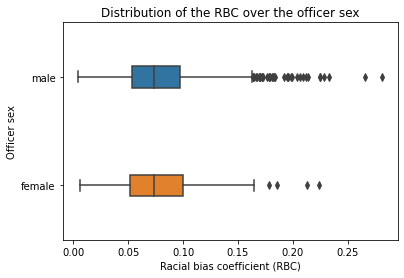

In [30]:
sex_df = officers_RBC_df[officers_RBC_df.officer_sex.isna() == False]

box_sex = sns.boxplot(x=sex_df.racial_bias_coefficient, y=sex_df.officer_sex, width=0.2)
box_sex.set(xlabel='Racial bias coefficient (RBC)', ylabel='Officer sex',
            title='Distribution of the RBC over the officer sex')
plt.savefig('./result/box_sex_RBC.png')

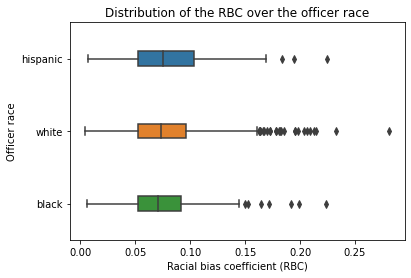

In [31]:
race_df = officers_RBC_df[officers_RBC_df.officer_race.isna() == False]

box_race = sns.boxplot(x=race_df.racial_bias_coefficient, y=race_df.officer_race, width=0.2)
box_race.set(xlabel='Racial bias coefficient (RBC)', ylabel='Officer race',
             title='Distribution of the RBC over the officer race')
plt.savefig('./result/box_race_RBC.png')

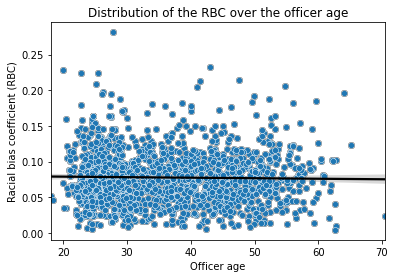

In [32]:
age_df = officers_RBC_df[officers_RBC_df.officer_age.isna() == False]
reg_age = sns.regplot(x=age_df.officer_age, y=age_df.racial_bias_coefficient, n_boot=1000, ci=95, color='black')
scatter_age = sns.scatterplot(x=age_df.officer_age, y=age_df.racial_bias_coefficient)
scatter_age.set(xlabel='Officer age', ylabel='Racial bias coefficient (RBC)',
                title='Distribution of the RBC over the officer age')
plt.savefig('./result/scatter_age_RBC.png')

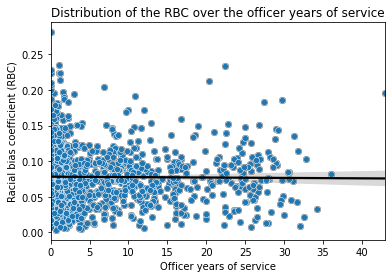

In [33]:
years_of_service_df = officers_RBC_df[officers_RBC_df.officer_years_of_service.isna() == False]
reg_years_of_service = sns.regplot(x=years_of_service_df.officer_years_of_service, y=years_of_service_df.racial_bias_coefficient, n_boot=1000, ci=95, color='black')
scatter_years_of_service = sns.scatterplot(x=years_of_service_df.officer_years_of_service, y=years_of_service_df.racial_bias_coefficient)
scatter_years_of_service.set(xlabel='Officer years of service', ylabel='Racial bias coefficient (RBC)',
                             title='Distribution of the RBC over the officer years of service')
plt.savefig('./result/scatter_yof_RBC.png')

NB: In the last version, dummies of officer sex and officer race were deleted

In [43]:
# Correlation between officer age and RBC
test = officers_RBC_df[officers_RBC_df.officer_age.isna() == False]

print(stats.pearsonr(test.officer_age, test.racial_bias_coefficient))
print(stats.spearmanr(test.officer_age, test.racial_bias_coefficient))

(-0.021021365350084885, 0.4118756134702617)
SpearmanrResult(correlation=-0.01862176085139026, pvalue=0.4672821161774763)


In [44]:
# Correlation between officer years of service and RBC

test = officers_RBC_df[officers_RBC_df.officer_years_of_service.isna() == False]

print(stats.pearsonr(test.officer_years_of_service, test.racial_bias_coefficient))
print(stats.spearmanr(test.officer_years_of_service, test.racial_bias_coefficient))

(-0.011664447573494678, 0.6270028697820643)
SpearmanrResult(correlation=-0.028726019071923584, pvalue=0.23132455943360858)


In [45]:
# Correlation between officer female and RBC

test = officers_RBC_df[officers_RBC_df.officer_sex_female.isna() == False]

print(stats.pearsonr(test.officer_sex_female, test.racial_bias_coefficient))
print(stats.spearmanr(test.officer_sex_female, test.racial_bias_coefficient))

(0.001421423563119798, 0.844010745232114)
SpearmanrResult(correlation=0.0032374583528995467, pvalue=0.6540389789416965)


In [46]:
# Correlation between officer male and RBC

test = officers_RBC_df[officers_RBC_df.officer_sex_male.isna() == False]

print(stats.pearsonr(test.officer_sex_male, test.racial_bias_coefficient))
print(stats.spearmanr(test.officer_sex_male, test.racial_bias_coefficient))

(-0.01603405623031708, 0.026438055444105713)
SpearmanrResult(correlation=-0.003253419036879372, pvalue=0.6524453301892162)


In [47]:
# Correlation between officer black and RBC

test = officers_RBC_df[officers_RBC_df.officer_race_black.isna() == False]

print(stats.pearsonr(test.officer_race_black, test.racial_bias_coefficient))
print(stats.spearmanr(test.officer_race_black, test.racial_bias_coefficient))

(-0.015426699496571538, 0.032710012467949974)
SpearmanrResult(correlation=-0.01107971946308197, pvalue=0.12507934615868402)


In [48]:
# Correlation between officer hispanic and RBC

test = officers_RBC_df[officers_RBC_df.officer_race_hispanic.isna() == False]

print(stats.pearsonr(test.officer_race_hispanic, test.racial_bias_coefficient))
print(stats.spearmanr(test.officer_race_hispanic, test.racial_bias_coefficient))

(-0.0008368100105946887, 0.9077805158035515)
SpearmanrResult(correlation=0.003686600754374573, pvalue=0.609818174907772)


In [49]:
# Correlation between officer white and RBC

test = officers_RBC_df[officers_RBC_df.officer_race_white.isna() == False]

print(stats.pearsonr(test.officer_race_white, test.racial_bias_coefficient))
print(stats.spearmanr(test.officer_race_white, test.racial_bias_coefficient))

(-0.013821712380587721, 0.055695224717736795)
SpearmanrResult(correlation=-0.003630116563716889, pvalue=0.6153060723361142)


In [50]:
test = officers_RBC_df[officers_RBC_df['officer_race_asian/pacific islander'].isna() == False]

print(stats.pearsonr(test['officer_race_asian/pacific islander'], test.racial_bias_coefficient))
print(stats.spearmanr(test['officer_race_asian/pacific islander'], test.racial_bias_coefficient))

(0.0062113880803386584, 0.3898758355608162)
SpearmanrResult(correlation=0.010272328325603703, pvalue=0.15501975236025925)


We can not that pearson's and spearman's coefficient have p value > 5% for the majority of test, so we can not make conclusion. For some test (correlation between officer male and RBC / correlation between officer black and RBC), the p value is under 5% and the conclusion of the tests is that officer male and officer black are only a few correlate to the RBC (which go in the same way that the analysis by distribution of the RBC across officer sex and officer race).